In [5]:
import tensorflow as tf
import numpy as np
from util.utils import *
from model.generator import Generator
from model.discriminator import Discriminator
from model.Layers import *
from model.StyleGan import StyleGAN



In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Found 21 files belonging to 1 classes.

Model resolution:4x4
STABLE
2000/2000 [==============================] - 39s 18ms/step - d_loss: -14.7366 - g_loss: 9.1025


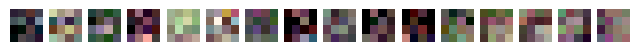


Model resolution:8x8
TRANSITION
2000/2000 [==============================] - 117s 55ms/step - d_loss: -25.4963 - g_loss: 18.6437


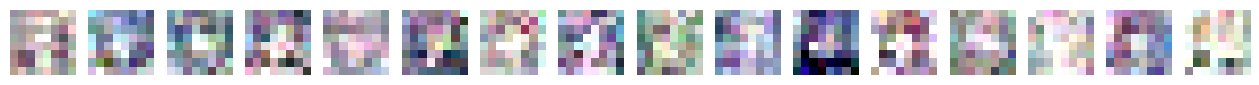

STABLE
2000/2000 [==============================] - 112s 55ms/step - d_loss: -32.2499 - g_loss: 21.3601


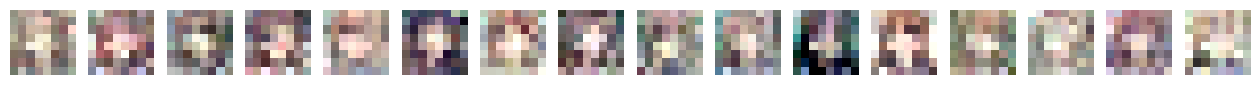


Model resolution:16x16
TRANSITION
2000/2000 [==============================] - 250s 121ms/step - d_loss: -60.9270 - g_loss: 46.1726


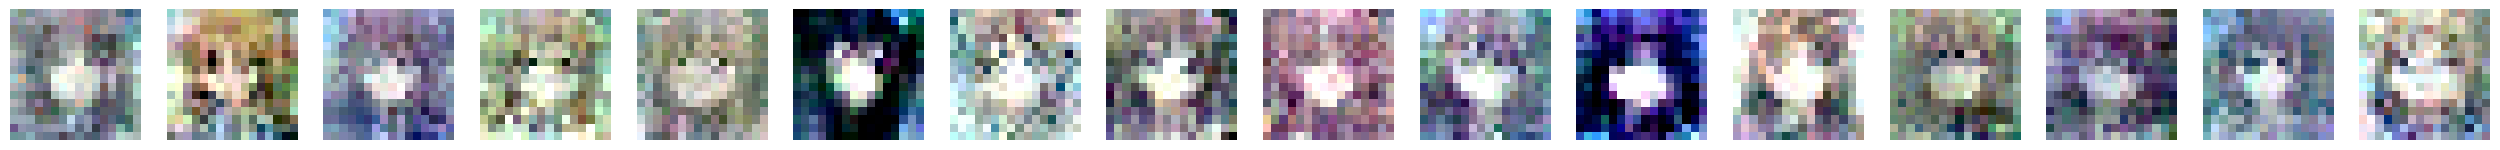

STABLE
2000/2000 [==============================] - 243s 121ms/step - d_loss: -73.3348 - g_loss: 55.5210


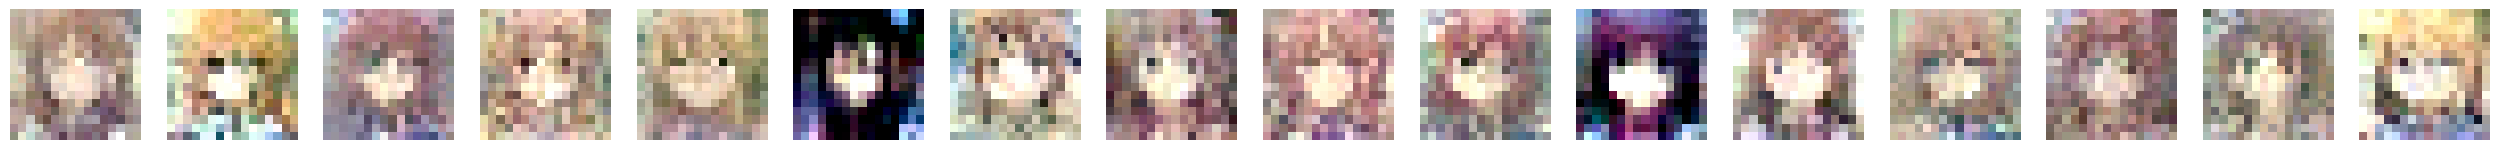


Model resolution:32x32
TRANSITION
2000/2000 [==============================] - 619s 304ms/step - d_loss: -140.2991 - g_loss: 116.4668


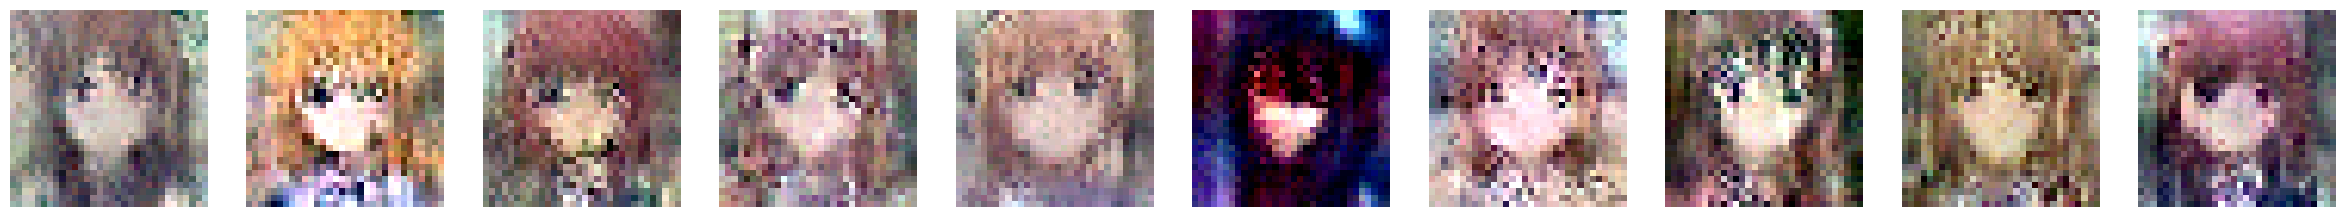

STABLE
2000/2000 [==============================] - 610s 304ms/step - d_loss: -148.3746 - g_loss: 123.0595


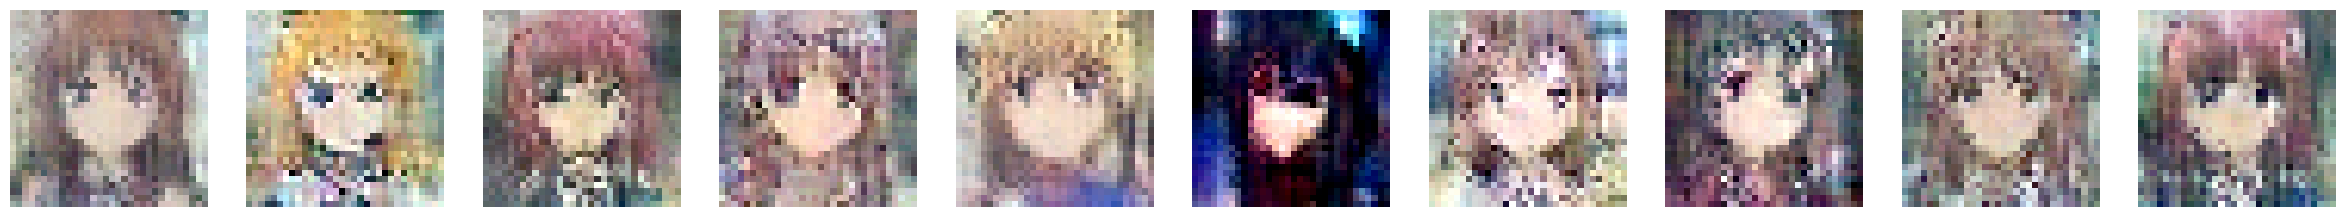


Model resolution:64x64
TRANSITION
2000/2000 [==============================] - 1255s 616ms/step - d_loss: -297.5233 - g_loss: 259.3167


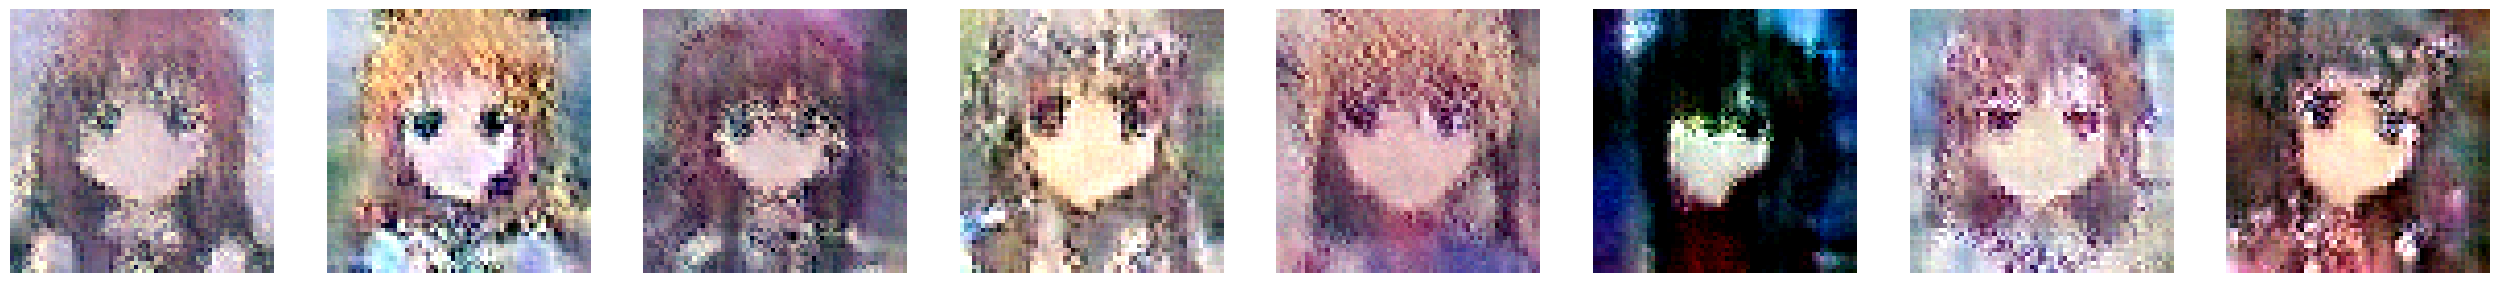

STABLE
2000/2000 [==============================] - 1236s 616ms/step - d_loss: -284.2485 - g_loss: 249.7141


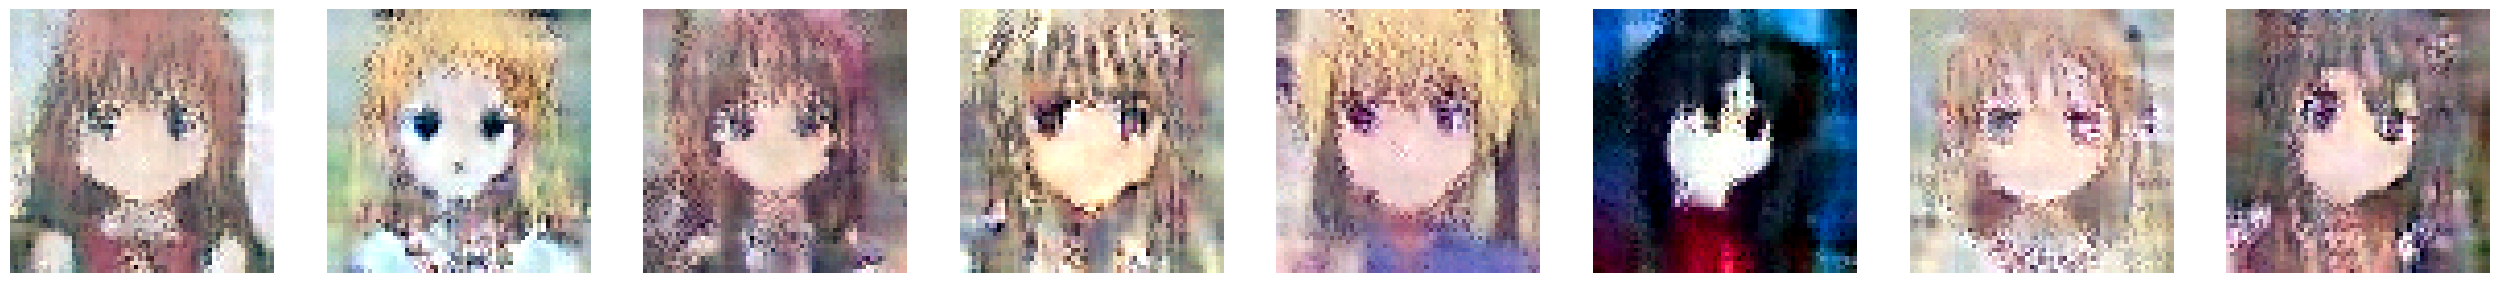


Model resolution:128x128
TRANSITION
4000/4000 [==============================] - 2851s 706ms/step - d_loss: -347.7767 - g_loss: 310.0970


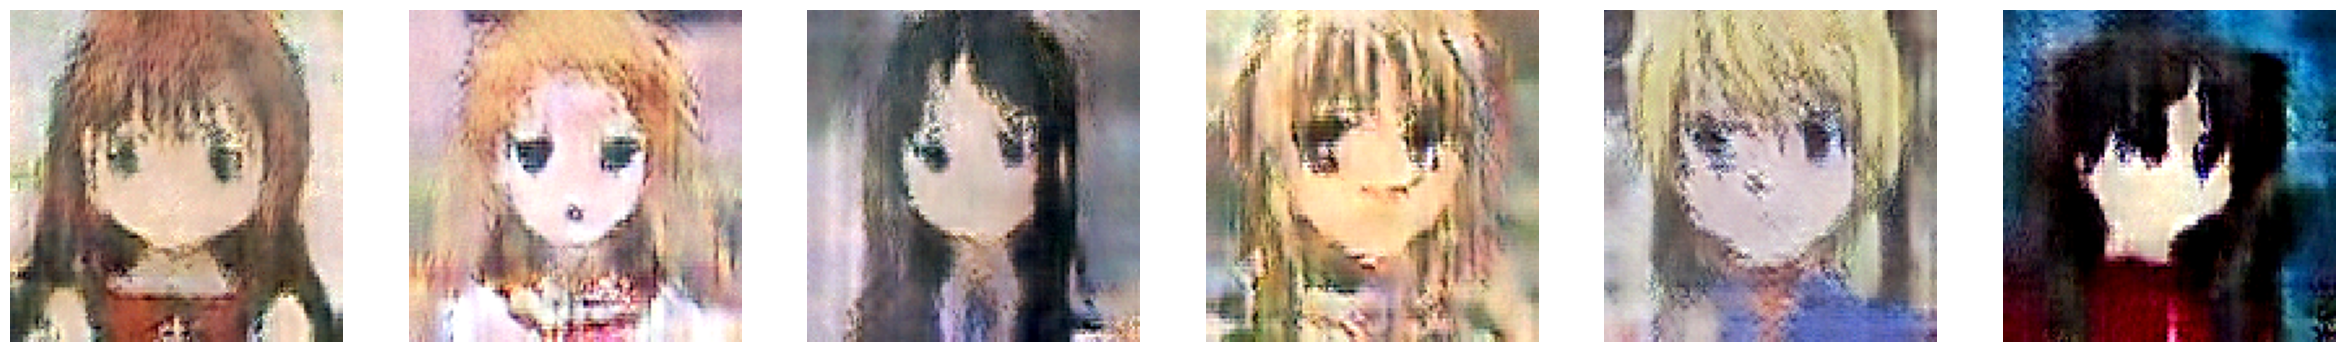

STABLE
4000/4000 [==============================] - 2827s 706ms/step - d_loss: -307.0502 - g_loss: 272.4826


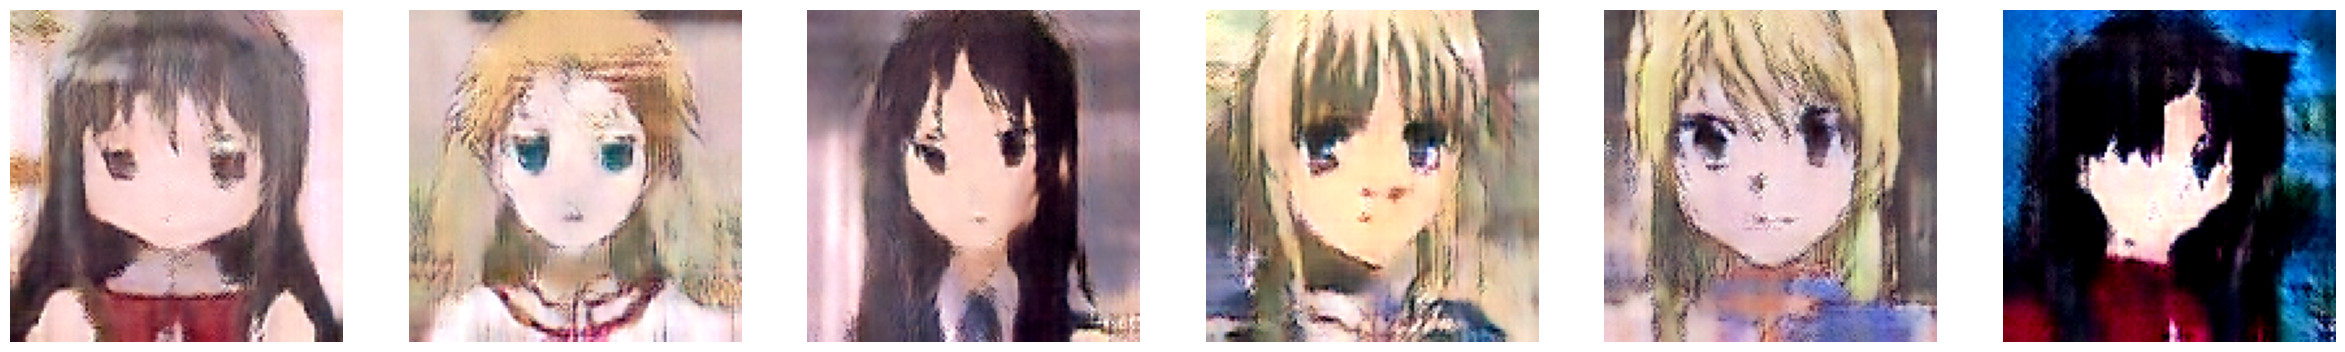

In [8]:
START_RES = 4
TARGET_RES = 128

style_gan = StyleGAN(start_res=START_RES, target_res=TARGET_RES)

def train(start_res=START_RES, target_res=TARGET_RES, steps_per_epoch=5000, display_images=True):
    opt_cfg = {'learning_rate':1e-3, 'beta_1':0.0, 'beta_2':0.99, 'epsilon':1e-8}

    val_batch_size = 16
    val_z = tf.random.normal((val_batch_size, style_gan.z_dim))  
    val_noise = style_gan.generate_noise(val_batch_size)
    
    start_res_log2 = int(np.log2(start_res))
    target_res_log2 = int(np.log2(target_res))

    for res_log2 in range(start_res_log2, target_res_log2+1):
        res = 2**res_log2
        for phase in ['TRANSITION', 'STABLE']:
            if res==start_res and phase=='TRANSITION':
                continue

            train_dl = create_dataloader(res)

            steps = int(train_step_ratio[res_log2] * steps_per_epoch)

            style_gan.compile(d_optimizer=tf.keras.optimizers.Adam(**opt_cfg),
                              g_optimizer=tf.keras.optimizers.Adam(**opt_cfg), 
                              loss_weights = {'gradient_penalty':10, 'drift':0.001},
                              steps_per_epoch=steps,
                              res=res,
                              phase=phase, run_eagerly=False)

            prefix = f'res_{res}x{res}_{style_gan.phase}'

            ckpt_cb = keras.callbacks.ModelCheckpoint(f'checkpoints/stylegan_{res}x{res}.ckpt', 
                                      save_weights_only=True, verbose=0)
            print(phase)
            style_gan.fit(train_dl, epochs=1, 
                          steps_per_epoch=steps, callbacks=[ckpt_cb])

            if display_images:
                images = style_gan({'z':val_z, 'noise':val_noise, 'alpha':1.0})
                plot_images(images, res_log2)        


def resize_image(resolution, image):
    image = tf.image.resize(
        image, (resolution,resolution), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.cast(image, tf.float32)/ 127.5 - 1.0

    return image

def create_dataloader(resolution):
    batch_size = batch_sizes[log2(resolution)]
    data_loader = data_train.map(partial(resize_image ,resolution), num_parallel_calls= tf.data.AUTOTUNE)
    data_loader = data_loader.shuffle(3).batch(batch_size, drop_remainder = True).prefetch(1).repeat()
    return data_loader

batch_sizes = {2:16, 3:16, 4:16, 5:16, 6:16, 7:8, 8:4} # 2**8
train_step_ratio = {k:batch_sizes[2] /v for k,v in batch_sizes.items()}
data_train = keras.utils.image_dataset_from_directory("trainB1/", label_mode = None, image_size=(256,256), batch_size= None)

train(steps_per_epoch=2000)